# Sentiment Classification with DistilBERT
Welcome to the workshop on fine-tuning DistilBERT for sentiment analysis on the IMDB dataset.

In this session, we will:
- Load and explore the IMDB dataset
- Preprocess the data
- Fine-tune a pre-trained DistilBERT model
- Evaluate the model's performance

## Setup
In this section, we will install the necessary libraries and load the IMDB dataset. This is the first step in preparing our environment for model training.


In [1]:
!pip install transformers datasets accelerate>=0.21.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [2]:
!pip install transformers[torch]
!pip install accelerate -U

In [3]:
from datasets import load_dataset

# Loading the IMDB dataset
imdb = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Exploring the Dataset (EDA)
Let's perform some exploratory data analysis to understand the structure and content of the IMDB dataset. We will look at basic statistics, random samples, and visualize the data distribution.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert dataset to DataFrame for easier manipulation
df_train = pd.DataFrame(imdb['train'])
df_test = pd.DataFrame(imdb['test'])

# Display basic statistics
print("Training set size:", len(df_train))
print("Test set size:", len(df_test))

# Display random samples from the dataset
print("\nRandom sample from the training set:")
df_train.sample(5)

Training set size: 25000
Test set size: 25000

Random sample from the training set:


,text,label
16281,When will people learn that some movies are ma...,1
6421,Unless you are geeky film student who has to s...,0
4451,Plot: an amorous couple decide to engage in so...,0
23118,Super Mario 64 is undoubtedly the greatest gam...,1
12362,Horror spoofs are not just a thing of the 21st...,0


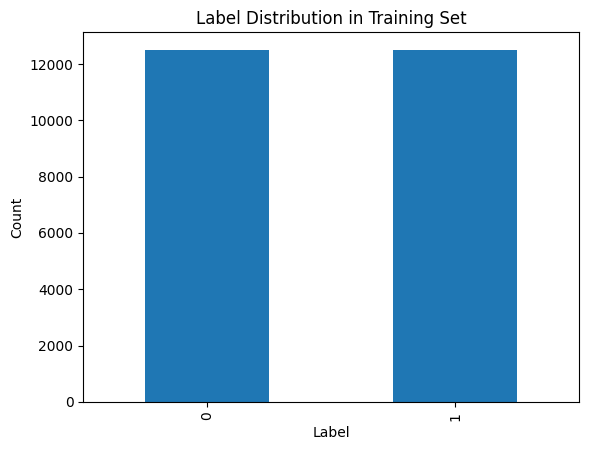

In [5]:
# Visualize data distribution
df_train['label'].value_counts().plot(kind='bar', title='Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Loading the Pre-trained Model and Tokenizer
We will use DistilBERT, a smaller and faster version of BERT. We need both the model and the tokenizer to process and classify the text data.


In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Check if a GPU is available and set device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device used: "+ device)

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Device used: cuda


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Preprocessing the Data
Tokenization is the process of converting text into numerical data that the model can process. We will use the tokenizer to convert our dataset. This should take about 3 minutes.


In [7]:
# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [8]:
# Sample 10,000 examples from the training and test splits
train_subset = imdb["train"].shuffle(seed=42).select(range(10000))
test_subset = imdb["test"].shuffle(seed=42).select(range(10000))

# Apply the tokenization to the entire dataset with multiprocessing
num_proc = 4
tokenized_train = train_subset.map(tokenize_function, batched=True, num_proc=num_proc)
tokenized_test = test_subset.map(tokenize_function, batched=True, num_proc=num_proc)

# Combine the tokenized subsets into a new dataset
tokenized_imdb = {
    "train": tokenized_train,
    "test": tokenized_test
}

Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

## Fine-Tuning the Model
Now, we will fine-tune our pre-trained model on the IMDB dataset. Fine-tuning involves training the model on a specific task to improve its performance.

### Training Arguments
- **output_dir:** Directory where the model's checkpoints will be saved.
- **eval_strategy:** When to evaluate the model (after each epoch).
- **learning_rate:** How fast the model learns. A smaller rate means more careful updates.
- **per_device_train_batch_size:** Number of samples per batch during training.
- **num_train_epochs:** Number of times to go through the entire training dataset.
- **weight_decay:** Regularization technique to avoid overfitting.


In [9]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
# TrainingArguments = hyperparameters
import torch

# Data collator that will dynamically pad the inputs
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,                       # Enable mixed precision training
    gradient_accumulation_steps=2,   # Gradient accumulation
)

### Initialize the Trainer
- **model**: The pre-trained model to be fine-tuned. In this case, it's DistilBertForSequenceClassification.
- **args**: The TrainingArguments object that specifies various training configurations like learning rate, batch size, number of epochs, etc.
- **train_dataset**: The dataset used for training the model. Here, it's the training split of the IMDb dataset.
- **eval_dataset**: The dataset used for evaluating the model's performance. Here, it's the test split of the IMDb dataset.
- **tokenizer**: The tokenizer associated with the pre-trained model. It tokenizes the input text into tokens that the model can understand.
- **data_collator**: The data collator is responsible for dynamically padding the inputs to ensure they are of uniform length during training.

In [10]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

### Train the model
**trainer.train()**: Starts the training process. The trainer will go through the training dataset for the specified number of epochs, updating the model's weights to minimize the loss. This process should take about 9 minutes.

In [11]:
# Train the model
trainer.train()

# Save the model
model.save_pretrained("./results")

Epoch,Training Loss,Validation Loss
0,No log,0.237705
2,No log,0.227389


## Evaluating the Model
After training, it's important to evaluate the model to understand its performance. We will use a function to calculate the accuracy of our model on the test dataset.


In [12]:
# @title Run it, code doesn't matter. { display-mode: "form" }
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load the trained model
model = DistilBertForSequenceClassification.from_pretrained("./results").to(device)

# Function to make predictions
def predict(sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits
    logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()

    # Get the predicted class label
    predicted_class = torch.argmax(logits, dim=1).cpu().numpy()

    return predicted_class, probabilities

In [17]:
# Test the model with a sentence
sentence = "The movie was badass."
predicted_class, probabilities = predict(sentence)
# 1 positive , 0 negative
print(f"Predicted class: {predicted_class[0]}")
print(f"Probabilities: {probabilities[0]}")

Predicted class: 0
Probabilities: [0.96761715 0.03238286]


In [14]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Conclusion
Congratulations on fine-tuning your first BERT model!

In this workshop, we:
- Loaded and explored the IMDB dataset
- Preprocessed the data and fine-tuned a DistilBERT model
- Evaluated the model's performance

Feel free to ask any questions or experiment further!
